In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Configuration
raw_dir = '../datasets/kaggle_m5_walmart_daily_raw'
output_file = '../datasets/m5_walmart_hobbies_daily.csv'

# Files
calendar_file = f'{raw_dir}/calendar.csv'
sales_file = f'{raw_dir}/sales_train_evaluation.csv'

In [2]:
# 1. Load Calendar Data
# We need this to map 'd_1', 'd_2'... to actual dates and get holiday info
try:
    df_cal = pd.read_csv(calendar_file)
    print("Calendar loaded.")
    print(df_cal.head())
except Exception as e:
    print(f"Error loading calendar: {e}")

Calendar loaded.
         date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1  


In [3]:
# 2. Load Sales Data (Evaluation)
# This file is wide. We need to filter for 'HOBBIES' category and aggregate.
try:
    # Loading only necessary columns might be hard because d_x columns are many.
    # We load everything but will filter quickly to save memory.
    df_sales = pd.read_csv(sales_file)
    print("Sales data loaded.")
    
    # Filter for HOBBIES category
    df_hobbies = df_sales[df_sales['cat_id'] == 'HOBBIES'].copy()
    print(f"Filtered HOBBIES shape: {df_hobbies.shape}")
    
except Exception as e:
    print(f"Error loading sales: {e}")

Sales data loaded.
Filtered HOBBIES shape: (5650, 1947)


In [4]:
# 3. Aggregate and Melt
# We want total HOBBIES sales across all stores/states per day.

# Identify day columns (d_1, d_2, ...)
d_cols = [c for c in df_hobbies.columns if 'd_' in c]

# Sum across all items/stores for each day
daily_sales = df_hobbies[d_cols].sum(axis=0)

# Convert to DataFrame
df_ts = daily_sales.to_frame(name='sales')
df_ts.index.name = 'd'
df_ts.reset_index(inplace=True)

print("Aggregated Time Series:")
print(df_ts.head())

Aggregated Time Series:
     d  sales
0  d_1   3764
1  d_2   3357
2  d_3   2682
3  d_4   2669
4  d_5   1814


In [8]:
# 4. Merge with Calendar
# We need to join df_ts['d'] with df_cal['d']

# Select relevant calendar columns
# date: for indexing
# event_name_1: Holiday/Event name
# event_type_1: Type of event
# snap_CA, snap_TX, snap_WI: Food stamp days (might affect disposable income for hobbies?)
cal_cols = ['date', 'd', 'event_name_1', 'event_type_1', 'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI']
df_cal_subset = df_cal[cal_cols].copy()

# Merge
df_final = pd.merge(df_ts, df_cal_subset, on='d', how='left')

# Convert date to datetime
df_final['timestamp'] = pd.to_datetime(df_final['date'])
df_final.set_index('timestamp', inplace=True)

# Fill NaN events with 'NoEvent'
df_final['event_name_1'] = df_final['event_name_1'].fillna('NoEvent')
df_final['event_type_1'] = df_final['event_type_1'].fillna('NoEvent')

# Create a combined SNAP index (just sum of snaps, as a proxy for general welfare distribution days)
df_final['snap_total'] = df_final['snap_CA'] + df_final['snap_TX'] + df_final['snap_WI']

# Drop the 'd' and original 'date' column as it's no longer needed
df_final.drop(columns=['d', 'date', 'snap_CA', 'snap_TX', 'snap_WI'], inplace=True)

print("Final Dataset Head:")
print(df_final.head())

Final Dataset Head:
            sales event_name_1 event_type_1  wday  month  year  snap_total
timestamp                                                                 
2011-01-29   3764      NoEvent      NoEvent     1      1  2011           0
2011-01-30   3357      NoEvent      NoEvent     2      1  2011           0
2011-01-31   2682      NoEvent      NoEvent     3      1  2011           0
2011-02-01   2669      NoEvent      NoEvent     4      2  2011           2
2011-02-02   1814      NoEvent      NoEvent     5      2  2011           2


In [9]:
# 5. Save Processed Data
df_final.to_csv(output_file)
print(f"Processed data saved to: {output_file}")

Processed data saved to: ../datasets/m5_walmart_hobbies_daily.csv


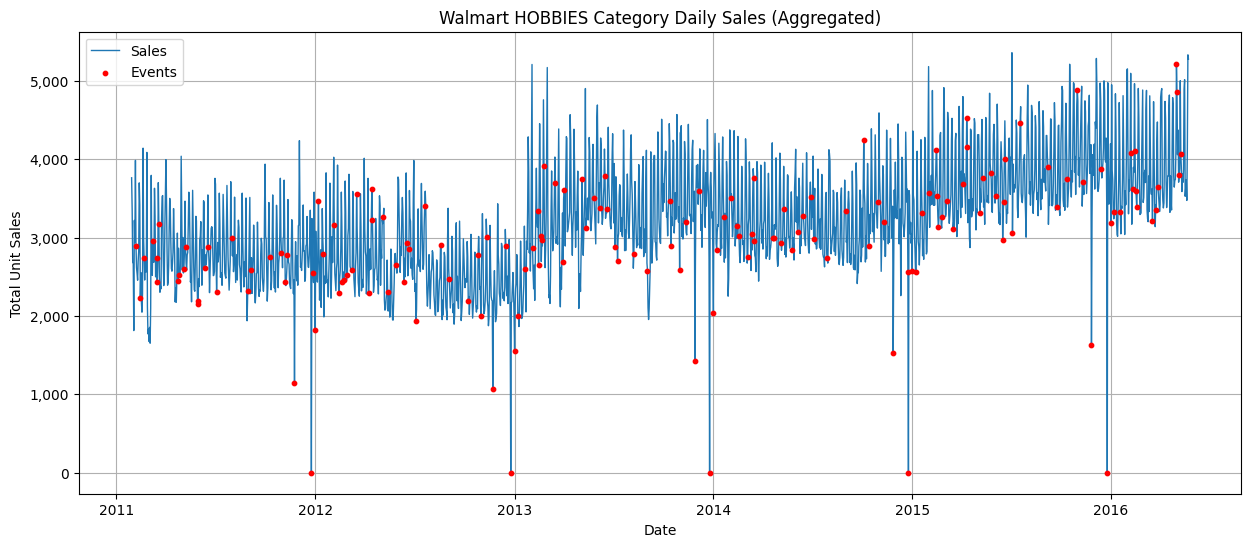

In [10]:
# 6. Visualization Check
plt.figure(figsize=(15, 6))
plt.plot(df_final.index, df_final['sales'], linestyle='-', linewidth=1, label='Sales')

# Highlight holidays (just a few to check)
holidays = df_final[df_final['event_name_1'] != 'NoEvent']
plt.scatter(holidays.index, holidays['sales'], color='red', s=10, label='Events', zorder=3)

plt.title('Walmart HOBBIES Category Daily Sales (Aggregated)')
plt.xlabel('Date')
plt.ylabel('Total Unit Sales')
plt.legend()
plt.grid(True)

# Format y-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()